In [2]:
# Modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import constants as const
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
print(tf.__version__)

#import sciann as sn
#from scipy import stats
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import mean_absolute_error, mean_squared_error
import statistics


2.8.1


In [3]:
# Import dataset using pandas

raw_dataset = pd.read_csv('../Dataset/Dataset_reduced.csv')
dataset = raw_dataset.copy()
print("Shape of dataset: "+str(dataset.shape))
dataset.tail()

Shape of dataset: (744521, 6)


,turbine,V,theta,W,T,P
744516,R80736,20.48,0.293564,1.801180,10817.3,2041980.0
744517,R80790,20.50,0.307352,1.799085,10837.3,2043120.0
744518,R80711,20.78,0.323933,1.799085,10850.1,2045870.0
744519,R80790,20.94,0.341386,1.799085,10853.8,2046570.0
744520,R80711,21.67,0.347670,1.798038,10871.8,2048260.0


In [4]:
# Clean dataset of NaN values
#dataset.isna().sum()
print(dataset.isna().sum())
dataset = dataset.dropna()

turbine    0
V          0
theta      0
W          0
T          0
P          0
dtype: int64


In [5]:
# One-hot encode categorical columns

dataset['turbine'] = dataset['turbine'].map({1:'R80711', 2:'R80721',3:'R80736', 4:'R80790'})
dataset = pd.get_dummies(dataset, columns=['turbine'], prefix='', prefix_sep='')
dataset.tail()

,V,theta,W,T,P
744516,20.48,0.293564,1.801180,10817.3,2041980.0
744517,20.50,0.307352,1.799085,10837.3,2043120.0
744518,20.78,0.323933,1.799085,10850.1,2045870.0
744519,20.94,0.341386,1.799085,10853.8,2046570.0
744520,21.67,0.347670,1.798038,10871.8,2048260.0


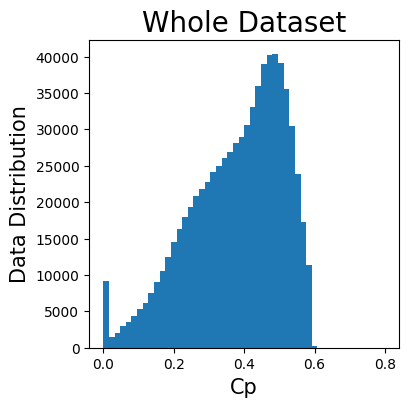

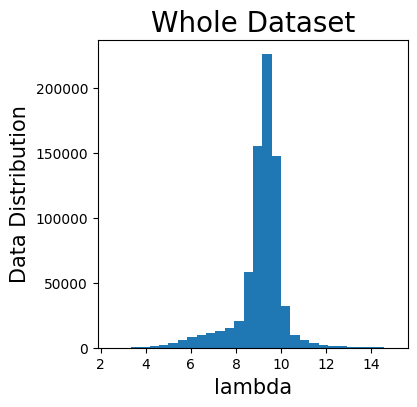

,V,theta,W,T,P,Cp,lambda
744516,20.48,0.293564,1.801180,10817.3,2041980.0,0.073492,3.605878
744517,20.50,0.307352,1.799085,10837.3,2043120.0,0.073318,3.598171
744518,20.78,0.323933,1.799085,10850.1,2045870.0,0.070489,3.549687
744519,20.94,0.341386,1.799085,10853.8,2046570.0,0.068909,3.522565
744520,21.67,0.347670,1.798038,10871.8,2048260.0,0.062228,3.401918


In [6]:
# Add Cp and lambda to the dataset

def Cp_fromP(Pturbina, Vw):

    Cp = Pturbina / (0.5 * const.rho * const.A * Vw**3)

    return Cp

def lambd(Vw, Wwt):

    lambd = Wwt * const.R / Vw

    return lambd

Cp_data = Cp_fromP(dataset['P'][:],dataset['V'][:])
dataset['Cp'] = Cp_data
lambd_data = lambd(dataset['V'][:], dataset['W'][:])
dataset['lambda'] = lambd_data

# Remove data with Cp>0.5926
#Cp_max = 0.5926
#dataset = dataset[ (dataset['Cp'] < Cp_max) ]

plt.figure(figsize=(4,4))
plt.hist(Cp_data, range=[0.0, 0.8], bins=50)
plt.xlabel('Cp',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

# Histogram of lambda
plt.figure(figsize=(4,4))
plt.hist(lambd_data, range=[2.5, 15], bins=30)
plt.xlabel('lambda',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

dataset.tail()

In [7]:
# Split the data into training and test sets

train_dataset = dataset.sample(frac=0.8, random_state=10)
test_dataset = dataset.drop(train_dataset.index)

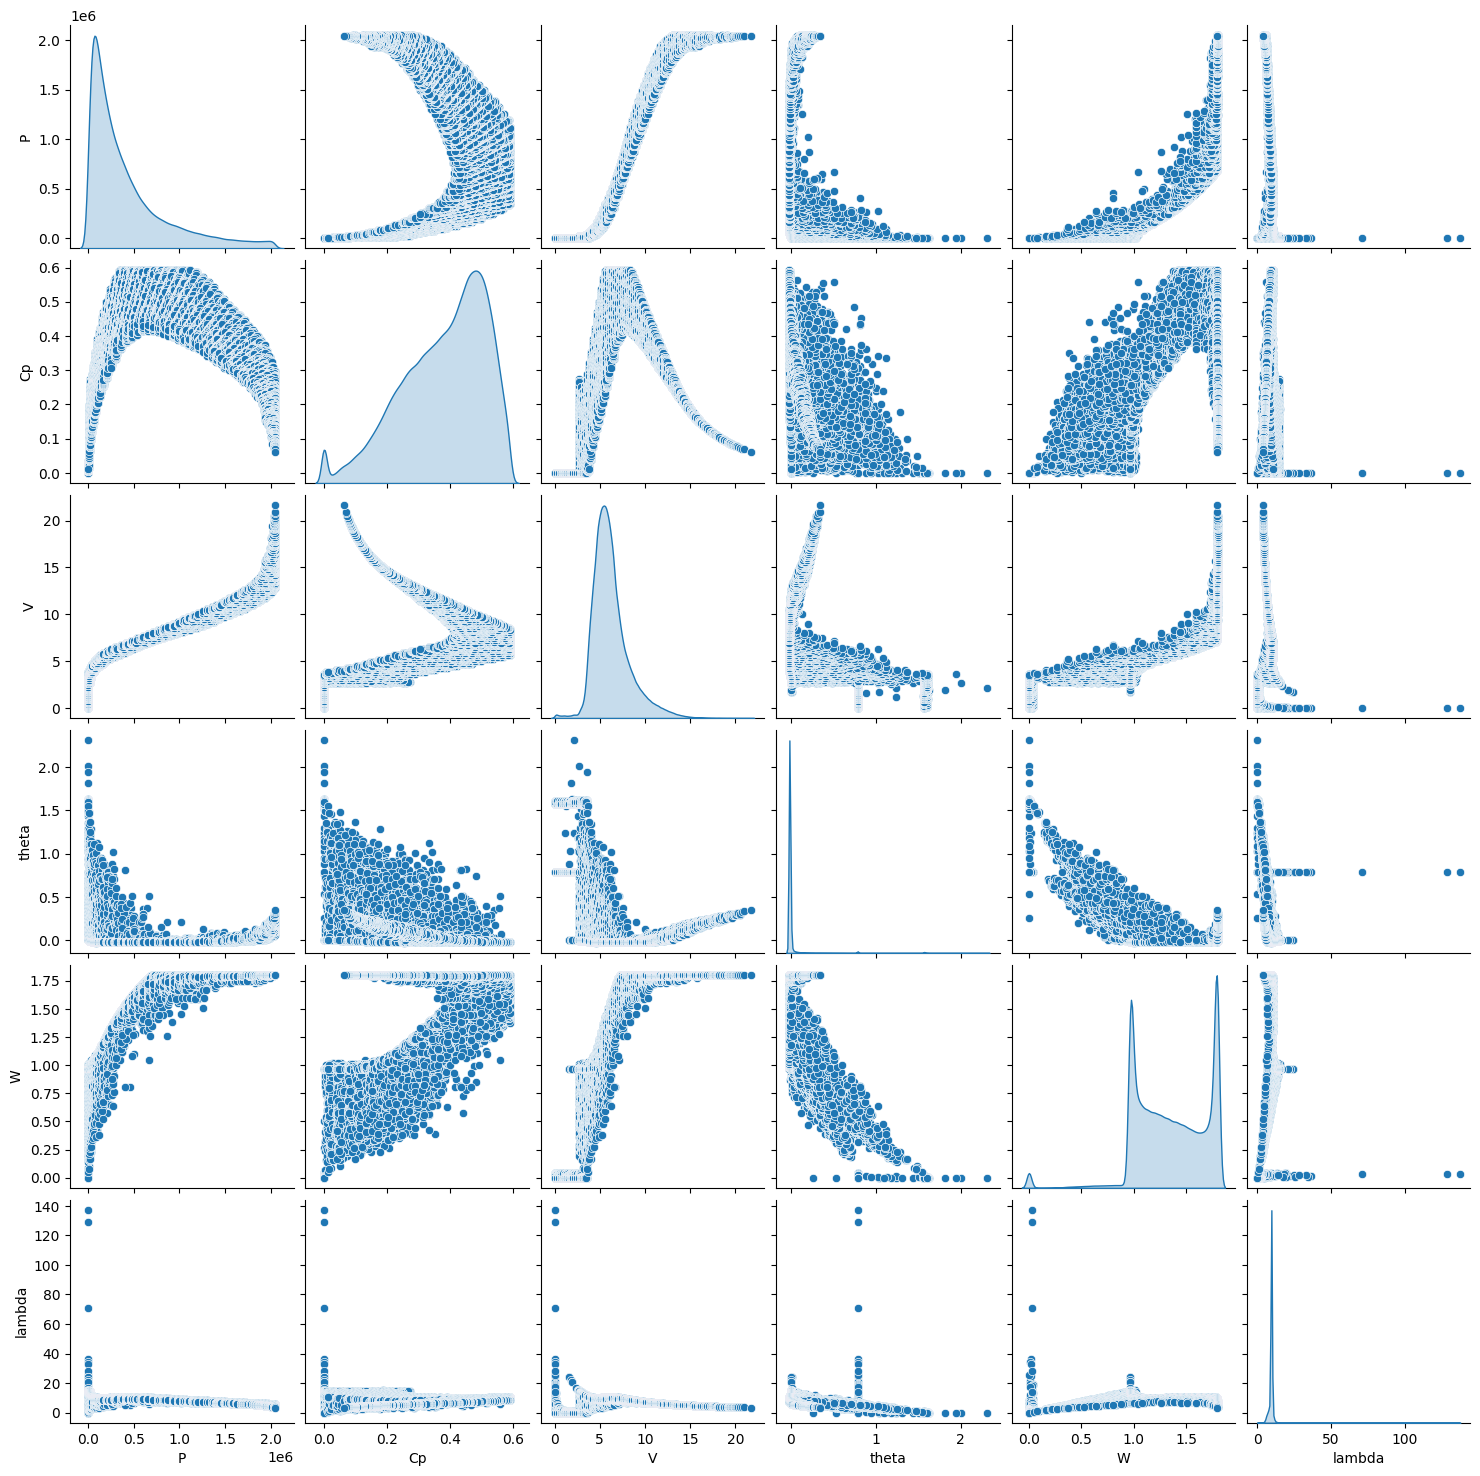

In [7]:
# Inspect the data with the joint distribition of a few pairs of columns from the training set

sns.pairplot(dataset[['P', 'Cp', 'V', 'theta', 'W', 'lambda']], diag_kind='kde')


In [8]:
# Check overal statistis of each input feature 
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
V,744521.0,6.209199,2.030771,0.010000,4.890000,5.830000,7.050000,2.167000e+01
theta,744521.0,0.005094,0.134292,-0.026704,-0.017453,-0.017279,-0.015184,2.312212e+00
W,744521.0,1.345151,0.336170,0.000000,1.072330,1.334130,1.653525,1.803274e+00
T,744521.0,2561.384767,2247.582292,0.000000,983.969970,1913.770000,3325.110100,1.087570e+04
P,744521.0,430038.754440,442298.427253,0.000000,112810.000000,271950.010000,584780.030000,2.051870e+06
Cp,744521.0,0.378574,0.132536,0.000000,0.288474,0.402581,0.484867,5.925997e-01
lambda,744521.0,9.023780,1.409913,0.000000,8.858880,9.280036,9.623638,1.373923e+02


In [9]:
# Normalization

print(dataset.describe().transpose()[['mean', 'std']])

#tf.enable_eager_execution()
#normalizer = tf.keras.layers.Normalization(axis=-1)
#normalizer.adapt(np.array(train_features))

# adapt() method does not work, so we standarize each feature by hand

""" V = np.array(train_features['V'])
theta = np.array(train_features['theta'])
W = np.array(train_features['W'])
#Torque = np.array(train_labels['T'])
#Power = np.array(train_labels['P'])
Power = np.array(train_labels)

V_avrg = np.average(V[:])
V_std = np.std(V[:])
theta_avrg = np.average(theta[:])
theta_std = np.std(theta[:])
W_avrg = np.average(W[:])
W_std = np.std(W[:])
#T_avrg = np.average(Torque[:])
#T_std = np.std(Torque[:])
P_avrg = np.average(Power[:])
P_std = np.std(Power[:])

V[:] = ( V[:] - V_avrg ) / V_std
theta[:] = ( theta[:] - theta_avrg ) / theta_std
W[:] = ( W[:] - W_avrg ) / W_std
#Torque[:] = ( Torque[:] - T_avrg ) / T_std
Power[:] = ( Power[:] - P_avrg ) / P_std
 """

# Normalize pandas dataframe
#train_features=(train_features-train_features.mean())/train_features.std()
#test_features=(test_features-test_features.mean())/test_features.std()
#train_labels=(train_labels-train_labels.mean())/train_labels.std()
#test_features=(test_labels-test_labels.mean())/test_labels.std()

train_dataset_norm=(train_dataset-dataset.mean())/dataset.std()
test_dataset_norm=(test_dataset-dataset.mean())/dataset.std()

print()
print("Normalized dataset")
print(train_dataset_norm.describe().transpose()[['mean', 'std']])

                 mean            std
V            6.209199       2.030771
theta        0.005094       0.134292
W            1.345151       0.336170
T         2561.384767    2247.582292
P       430038.754440  442298.427253
Cp           0.378574       0.132536
lambda       9.023780       1.409913

Normalized dataset
            mean       std
V      -0.000229  0.999412
theta   0.000163  1.000438
W      -0.000046  1.000431
T      -0.000126  0.999534
P      -0.000159  0.999546
Cp      0.000251  0.999821
lambda -0.000337  1.003608


In [10]:
# Split features from labels/targets

train_dataset_copy = train_dataset_norm.copy()
test_dataset_copy = test_dataset_norm.copy()

train_features = train_dataset_copy[['lambda','theta']]
test_features = test_dataset_copy[['lambda','theta']]

train_labels = train_dataset_copy.pop('Cp')
test_labels = test_dataset_copy.pop('Cp')

print(train_features.shape)
print(train_labels.shape)

(595617, 2)
(595617,)


In [ ]:
# 1-input linear model 

""" x = np.array(train_features['V'])
inputs = tf.keras.Input(shape=(1,))

model = tf.keras.Sequential([
    inputs,
    layers.Dense(units=1)
])

model.summary() """


In [11]:
# Define the hypermodel to optimize hyperparameters
 
def model_builder(hp):
  
  #input = tf.keras.Input(shape=(3,))
  input = tf.keras.Input(shape=(2,))
  model = keras.Sequential()

  # Tune the number of units in the Dense layers
  # Choose an optimal value between 8-128
  hp_units = hp.Int('units', min_value=8, max_value=128, step=2, sampling='log')
  
  # Tune the number of layers between 1-4
  #hp_layers = hp.Int('layers', min_value=1, max_value=4, step=1)
  #hp_layers = hp.Int('layers', min_value=1, max_value=4, step=1, sampling='linear')
  hp_layers = hp.Int('layers', min_value=1, max_value=4, step=2, sampling='log')

  # Tune activation function between relu, tanh and sigmoid
  #hp_activation = hp.Choice('activation', values=['relu','tanh','sigmoid'])
  hp_activation = hp.Choice('activation', values=['relu','tanh'])

  # Define architecture
  model.add(input)
  for i in range(hp_layers):
    #model.add(keras.layers.Dense(units=hp_units, activation='tanh'))
    model.add(keras.layers.Dense(units=hp_units, activation=hp_activation))
  model.add(keras.layers.Dense(1))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  # Tune the batch size
  #hp_batch = hp.Int('batch', min_value=32, max_value=256, step=2, sampling='log')

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                #loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                #metrics=['accuracy'])
                loss='mean_absolute_error')   

  return model

In [12]:
# Instantiate the tuner and perform hypertuning

tuner = kt.Hyperband(model_builder,
                     #objective='val_accuracy',
                     objective='val_loss',
                     #max_epochs=10,
                     max_epochs=20,
                     factor=3,
                     #factor=2,
                     directory='./Hypertuning',
                     project_name='hypertuning_Cp')


2023-03-16 09:40:42.071755: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-16 09:40:42.112234: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-03-16 09:40:42.112257: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-03-16 09:40:42.113140: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

In [13]:
# Create a callback to stop training early after reaching a certain value for the validation loss.
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

#x = train_features[['V','theta','W']]
x = train_features  # input features are lambda and theta
# search() method receives same arguments as fit() method, plus callbacks
# if batch_size is not specified, 32 is the default value
tuner.search(x, train_labels, epochs=20, validation_split=0.2, batch_size=128, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete! The optimal number of layers, number of units, 
learning rate and activation function are:
n_layers: {best_hps.get('layers')}
n_units: {best_hps.get('units')}
learning_rate: {best_hps.get('learning_rate')}
activation_function: {best_hps.get('activation')}
""")

Trial 30 Complete [00h 00m 42s]
val_loss: 0.3267706036567688

Best val_loss So Far: 0.31976714730262756
Total elapsed time: 00h 09m 08s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete! The optimal number of layers, number of units, 
learning rate and activation function are:
n_layers: 4
n_units: 64
learning_rate: 0.001
activation_function: relu



In [14]:
# Train the model with optimal hyperparameters

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, min_lr=1e-6)

# Build the model with the optimal hyperparameters and train it on the data for 500 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(x, train_labels, epochs=200, batch_size=128, validation_split=0.2, callbacks=[reduce_lr])


Epoch 1/200
3723/3723 [==============================] - 4s 894us/step - loss: 0.3478 - val_loss: 0.3377 - lr: 0.0010
Epoch 2/200
3723/3723 [==============================] - 3s 859us/step - loss: 0.3268 - val_loss: 0.3311 - lr: 0.0010
Epoch 3/200
3723/3723 [==============================] - 3s 864us/step - loss: 0.3254 - val_loss: 0.3253 - lr: 0.0010
Epoch 4/200
3723/3723 [==============================] - 3s 863us/step - loss: 0.3245 - val_loss: 0.3245 - lr: 0.0010
Epoch 5/200
3723/3723 [==============================] - 3s 858us/step - loss: 0.3235 - val_loss: 0.3225 - lr: 0.0010
Epoch 6/200
3723/3723 [==============================] - 3s 851us/step - loss: 0.3229 - val_loss: 0.3234 - lr: 0.0010
Epoch 7/200
3723/3723 [==============================] - 3s 854us/step - loss: 0.3225 - val_loss: 0.3198 - lr: 0.0010
Epoch 8/200
3723/3723 [==============================] - 3s 855us/step - loss: 0.3224 - val_loss: 0.3213 - lr: 0.0010
Epoch 9/200
3723/3723 [==============================] -

Best epoch: 193


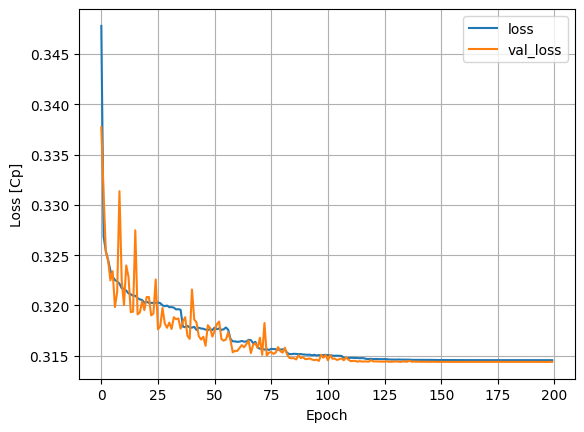

In [15]:
# Plot the loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
#plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Loss [Cp]')
plt.legend()
plt.grid(True)

val_loss_per_epoch = history.history['val_loss']
train_loss_per_epoch = history.history['loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [ ]:
""" # Re-instantiate the hypermodel and train it with the optimal number of epochs from above.

hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(x, train_labels, epochs=best_epoch, batch_size=128, validation_split=0.2, callbacks=[reduce_lr]) """


In [16]:
# save model weights 
#model.save_weights('./Models/Cp_model_weights.hdf5')

# load model weights
#model.load_weights('./Models/Cp_model_weights.hdf5')

# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('./Models/Cp_model.h5')

# Recreate the exact same model, including its weights and the optimizer
#new_model = tf.keras.models.load_model('my_model.h5')

# Show the model architecture
#new_model.summary()

In [13]:
# load model 

model = tf.keras.models.load_model('./Models/Cp_model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                96        
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,185
Trainable params: 1,185
Non-trainable params: 0
_________________________________________________________________


2023-03-15 08:28:34.282893: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-15 08:28:34.313516: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-03-15 08:28:34.313534: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-03-15 08:28:34.314216: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

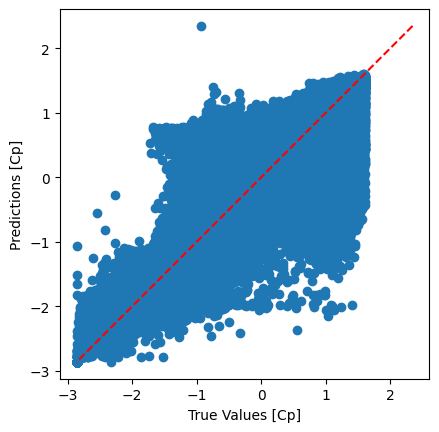

Test MAE: 0.31527453660964966


In [17]:
# Evaluate the model on Cp data

# Pred vs True values

test_pred = model.predict(test_features[['lambda', 'theta']]).flatten()

a = plt.axes(aspect='equal')
p1 = max(max(test_pred), max(test_labels))
p2 = min(min(test_pred), min(test_labels))
plt.plot([p1, p2], [p1, p2], 'r--')
plt.scatter(test_labels, test_pred)
plt.xlabel('True Values [Cp]')
plt.ylabel('Predictions [Cp]')
plt.show()
#lims = [0, 50]
#plt.xlim(lims)
#plt.ylim(lims)
#_ = plt.plot(lims, lims)

test_result = model.evaluate(test_features[['lambda','theta']], test_labels, verbose=0)
print("Test MAE: "+str(test_result))

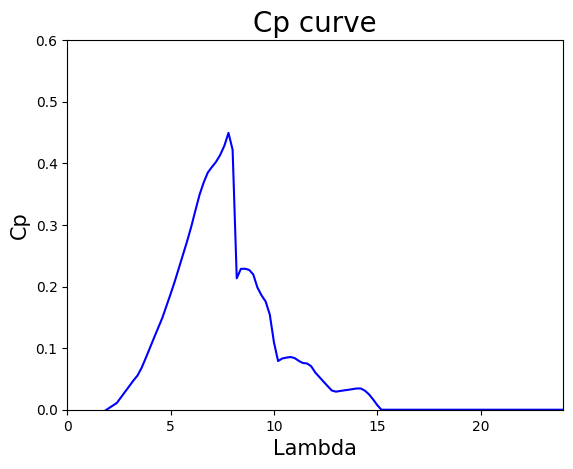

In [56]:
# Plot Cp vs lambda

lmin=0
lmax=50
lambda_values = np.arange(lmin,lmax,0.2)  
#theta_values = -0.8* np.ones(len(lambda_values))  # in degrees
theta_values = 1* np.ones(len(lambda_values))  # in degrees
theta_values = theta_values * np.pi / 180.0       # convert to rads

# normalize inputs
x_norm = np.zeros((len(lambda_values),2))
x_lambda = (lambda_values - dataset['lambda'].mean()) / dataset['lambda'].std()
x_theta = (theta_values - dataset['theta'].mean()) / dataset['theta'].std()
x_norm[:,0] = x_lambda[:]
x_norm[:,1] = x_theta[:]

y_norm = model.predict(x_norm)
# de-normalize output
Cp_values = y_norm * dataset['Cp'].std() + dataset['Cp'].mean()

plt.figure()#figsize=(10,10))
plt.plot(lambda_values, Cp_values, 'b-')
plt.xlabel('Lambda',fontsize=15)
plt.ylabel('Cp',fontsize=15)
#plt.axis('equal')
plt.ylim([0, 0.6])
plt.xlim([0, 24])
plt.title('Cp curve',fontsize=20)
plt.show()


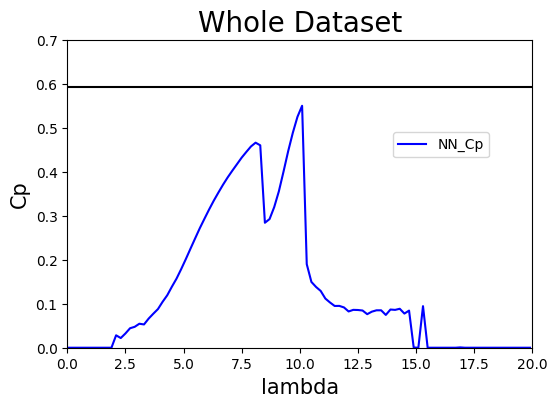

In [30]:
# Plot Cp vs lambda, averaging theta variable

# Prediction of Cp
x_norm = np.zeros((len(dataset['lambda']),2))
x_lambda = (dataset['lambda'] - dataset['lambda'].mean()) / dataset['lambda'].std()
x_theta = (dataset['theta'] - dataset['theta'].mean()) / dataset['theta'].std()
x_norm[:,0] = x_lambda[:]
x_norm[:,1] = x_theta[:]
Cp_norm = model.predict(x_norm)
Cp_pred = Cp_norm * dataset['Cp'].std() + dataset['Cp'].mean()

# Estimate the Cp curve with the median
lmin = 0
lmax = 20
nbins = 100
Cp_estimated = np.zeros(nbins)
lambd_estimated = np.zeros(nbins)
dl = (lmax-lmin)/nbins

for i in range(1,nbins):
    lambdal = lmin + i*dl
    lambdar = lambdal + dl

    # Median of Cp in the bin i
    lambd_estimated[i] = (lambdal+lambdar)/2.0
    l_subset = (lambdal<lambd_data) & (lambd_data<lambdar)  # subset of lambda points of the bin
    Cpi = Cp_data[l_subset]     # Cp distribution of bin i
    if (len(Cpi)>0):
        Cp_estimated[i]=statistics.median(Cpi)
        #Cp_estimated[i]=statistics.mean(Cpi)
        #Cp_estimated[i]=np.max(Cpi)
        #Cp_estimated[i]=np.percentile(Cpi,95)
    #else:
        #Cp_estimated[i]=Cp_estimated[i-1]

# Plot Cp vs lambda of all data
Cp_max = 0.5926
plt.figure(figsize=(6,4))
plt.xlabel('lambda',fontsize=15)
plt.ylabel('Cp',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
#plt.scatter(lambd_data, Cp_data,facecolors='none',edgecolors='blue')
#plt.scatter(lambd_data,Cp_predicted, facecolors='none',edgecolors='green')
plt.plot(lambd_estimated, Cp_estimated, 'b-',label='NN_Cp')
#plt.plot(lambd_estimated, Cp_estimated_NN, 'r-',label='Predicted')
#plt.plot(lambd_data, Cp_predicted, 'go')
#plt.plot(lambd_predicted,Cp_data,'bo')
plt.axhline(y=Cp_max, color = 'k', linestyle = '-')
plt.xlim([0,20])
plt.ylim([0,0.7])
l1 = plt.legend(bbox_to_anchor=(0.7, 0.7), borderaxespad=0)
plt.show()